# Type 2 → Type 5 Multi-Iteration Analysis (COMPLETE)

## PADBen: Paraphrase Attack Detection Benchmark
### CS6120 Natural Language Processing - Northeastern University

**Authors:** Zaid Shaikh, Rahul Leonard Arun Kumar, Aryan Singh  
**Advisor:** Prof. Shanu Sushmita
**Date:** December 2025

---

## Overview

This notebook provides a **comprehensive iterative semantic drift analysis** tracking:
- **Type 2:** LLM-Generated Text (baseline)
- **Type 5 (1st):** LLM-Paraphrased LLM text (1st iteration)
- **Type 5 (3rd):** LLM-Paraphrased LLM text (3rd iteration)

### Analysis Components:
1. **Hop-by-Hop Drift:** Type 2 → 5_1st → 5_3rd progression
2. **Cumulative Drift Tracking:** Accumulated semantic degradation
3. **Entity Preservation Analysis:** Named entity consistency across iterations
4. **Breaking Point Detection:** When does meaning collapse?

### Methodology (from SemanticDrift_MileStone2)
- **SBERT Embeddings:** Using `all-mpnet-base-v2` for high-quality sentence embeddings
- **Euclidean Distance:** Between embedding vectors
- **METEOR Score:** Translation evaluation metric
- **ROUGE-L:** Longest common subsequence
- **BERTScore:** Contextual embedding similarity
- **Composite SDS:** `0.6 * SBERT_norm + 0.2 * METEOR_norm + 0.2 * ROUGE_norm`

### ParaScore Integration
- **Reference-Free Evaluation:** Hop-by-hop without original reference
- **Threshold (γ = 0.35):** Quality collapse boundary
- **Multi-Iteration Tracking:** How drift accumulates

---

## Cell 1: Environment Setup and Dependencies

In [2]:
# Install required packages (run once)
# Packages are already installed - skip this cell

%pip install sentence-transformers nltk rouge-score bert-score scipy scikit-learn seaborn tqdm python-Levenshtein spacy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
# Core imports
import json
import re
import warnings
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# NLP Libraries
import nltk
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Sentence Transformers (SBERT)
from sentence_transformers import SentenceTransformer

# BERTScore
from bert_score import score as bert_score_compute

# Sklearn for normalization
from sklearn.preprocessing import MinMaxScaler

# scipy for distance metrics
from scipy.stats import spearmanr
from scipy.spatial.distance import euclidean

# Levenshtein for edit distance
from Levenshtein import distance as lev_distance

# SpaCy for NER (optional)
try:
    import spacy
    nlp = spacy.load('en_core_web_sm', disable=['lemmatizer'])
    SPACY_AVAILABLE = True
except:
    SPACY_AVAILABLE = False
    print("⚠️ SpaCy not available - entity analysis will be skipped")

# Suppress warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ All dependencies loaded successfully!")
print(f"   SpaCy available: {SPACY_AVAILABLE}")

/Users/zaidshaikh/GitHub/padben_eda_notebook/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All dependencies loaded successfully!
   SpaCy available: True


In [2]:
# Configuration
# ============================================================================

# Paths - Adjust based on your environment
DATA_PATH = Path('../../data.json')  # Relative to SDS_ParaScore/Type5_Iterative_MultiIteration/
OUTPUT_DIR = Path('.')  # Current directory

# Column names in data.json
COL_TYPE2 = 'llm_generated_text(type2)'
COL_TYPE5_1ST = 'llm_paraphrased_generated_text(type5)-1st'
COL_TYPE5_3RD = 'llm_paraphrased_generated_text(type5)-3rd'

# Also include Type 1 for reference comparison
COL_TYPE1 = 'human_original_text(type1)'

# ParaScore thresholds
PARASCORE_THRESHOLD = 0.35
LOW_MED_THRESHOLD = 0.35
MED_HIGH_THRESHOLD = 0.45

# Composite SDS weights (from SemanticDrift_MileStone2)
WEIGHT_SBERT = 0.6
WEIGHT_METEOR = 0.2
WEIGHT_ROUGE = 0.2

# Model configuration
SBERT_MODEL = 'all-mpnet-base-v2'

# Visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("✅ Configuration loaded!")
print(f"   Data path: {DATA_PATH}")
print(f"   Output dir: {OUTPUT_DIR}")
print(f"   SBERT model: {SBERT_MODEL}")

✅ Configuration loaded!
   Data path: ../../data.json
   Output dir: .
   SBERT model: all-mpnet-base-v2


## Cell 2: Data Loading

In [3]:
# Load the dataset
print("="*70)
print("📂 LOADING DATA")
print("="*70)

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Create standardized column names
df['Type_1'] = df[COL_TYPE1]  # Human original (for reference)
df['Type_2'] = df[COL_TYPE2]  # LLM generated (baseline)
df['Type_5_1st'] = df[COL_TYPE5_1ST]  # 1st iteration paraphrase
df['Type_5_3rd'] = df[COL_TYPE5_3RD]  # 3rd iteration paraphrase

print(f"\n✅ Loaded {len(df)} samples")
print(f"\n📊 Type Availability:")
print(f"   Type 2 (LLM Generated): {df['Type_2'].notna().sum()} samples")
print(f"   Type 5 (1st iteration): {df['Type_5_1st'].notna().sum()} samples")
print(f"   Type 5 (3rd iteration): {df['Type_5_3rd'].notna().sum()} samples")

📂 LOADING DATA

✅ Loaded 5000 samples

📊 Type Availability:
   Type 2 (LLM Generated): 5000 samples
   Type 5 (1st iteration): 5000 samples
   Type 5 (3rd iteration): 5000 samples


In [6]:
# Display sample iteration chain
print("\n📝 Sample Iteration Chain (Type 2 → 5_1st → 5_3rd):")
print("="*70)
for i in range(2):
    print(f"\n--- Sample {i+1} ---")
    print(f"Type 2 (LLM):     {df['Type_2'].iloc[i][:80]}...")
    print(f"Type 5 (1st):     {df['Type_5_1st'].iloc[i][:80]}...")
    print(f"Type 5 (3rd):     {df['Type_5_3rd'].iloc[i][:80]}...")


📝 Sample Iteration Chain (Type 2 → 5_1st → 5_3rd):

--- Sample 1 ---
Type 2 (LLM):     Amrozi accused his brother of being an accomplice in the Bali bombings, despite ...
Type 5 (1st):     Amrozi claimed his brother participated in the Bali bombings, without any suppor...
Type 5 (3rd):     Amrozi claimed his brother participated in the Bali bombings, yet provided no ev...

--- Sample 2 ---
Type 2 (LLM):     They had published an advertisement on the internet for the upcoming cargo sale ...
Type 5 (1st):     They had publicized the upcoming June cargo sale through an internet advertiseme...
Type 5 (3rd):     The company publicized its planned June shipping event through an online adverti...


## Cell 3: SBERT Model Loading

In [4]:
# Initialize SBERT model
print("="*70)
print(f"🤖 LOADING SBERT MODEL: {SBERT_MODEL}")
print("="*70)

sbert_model = SentenceTransformer(SBERT_MODEL)
print(f"✅ Model loaded successfully!")
print(f"   Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")

🤖 LOADING SBERT MODEL: all-mpnet-base-v2
✅ Model loaded successfully!
   Embedding dimension: 768
✅ Model loaded successfully!
   Embedding dimension: 768


## Cell 4: Comprehensive Metric Calculation Functions

In [5]:
# Helper functions
def simple_tokenize(text):
    """Simple tokenization"""
    return re.findall(r'\w+', str(text).lower())

def calculate_sbert_distance(embeddings1, embeddings2):
    """Calculate Euclidean distances between embedding pairs"""
    distances = []
    for emb1, emb2 in zip(embeddings1, embeddings2):
        distances.append(euclidean(emb1, emb2))
    return np.array(distances)

def calculate_meteor_scores(texts1, texts2):
    """Calculate METEOR scores"""
    scores = []
    for t1, t2 in tqdm(zip(texts1, texts2), total=len(texts1), desc="METEOR"):
        if pd.isna(t1) or pd.isna(t2):
            scores.append(np.nan)
            continue
        ref_tokens = simple_tokenize(t1)
        hyp_tokens = simple_tokenize(t2)
        scores.append(meteor_score([ref_tokens], hyp_tokens))
    return np.array(scores)

def calculate_rouge_scores(texts1, texts2):
    """Calculate ROUGE-L F-measure scores"""
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = []
    for t1, t2 in tqdm(zip(texts1, texts2), total=len(texts1), desc="ROUGE-L"):
        if pd.isna(t1) or pd.isna(t2):
            scores.append(np.nan)
            continue
        result = scorer.score(str(t1), str(t2))
        scores.append(result['rougeL'].fmeasure)
    return np.array(scores)

def calculate_jaccard(texts1, texts2):
    """Calculate Jaccard similarity"""
    scores = []
    for t1, t2 in zip(texts1, texts2):
        if pd.isna(t1) or pd.isna(t2):
            scores.append(np.nan)
            continue
        tokens1 = set(simple_tokenize(t1))
        tokens2 = set(simple_tokenize(t2))
        if not tokens1 and not tokens2:
            scores.append(1.0)
        else:
            scores.append(len(tokens1 & tokens2) / max(1, len(tokens1 | tokens2)))
    return np.array(scores)

def calculate_edit_distance(texts1, texts2):
    """Calculate normalized edit distance"""
    scores = []
    for t1, t2 in zip(texts1, texts2):
        if pd.isna(t1) or pd.isna(t2):
            scores.append(np.nan)
            continue
        max_len = max(len(str(t1)), len(str(t2)))
        if max_len == 0:
            scores.append(0.0)
        else:
            scores.append(lev_distance(str(t1), str(t2)) / max_len)
    return np.array(scores)

print("✅ Metric calculation functions defined!")

✅ Metric calculation functions defined!


In [6]:
def calculate_comprehensive_sds(texts_ref, texts_hyp, sbert_model, scaler=None):
    """
    Calculate comprehensive SDS between text pairs.
    
    Returns:
        dict with all metrics and composite SDS
    """
    print("   Computing SBERT embeddings...")
    # SBERT embeddings
    emb_ref = sbert_model.encode(texts_ref.tolist(), batch_size=32, show_progress_bar=True)
    emb_hyp = sbert_model.encode(texts_hyp.tolist(), batch_size=32, show_progress_bar=True)
    
    # Euclidean distance
    sbert_euclid = calculate_sbert_distance(emb_ref, emb_hyp)
    
    print("   Computing METEOR scores...")
    meteor = calculate_meteor_scores(texts_ref.tolist(), texts_hyp.tolist())
    meteor_inv = 1 - meteor
    
    print("   Computing ROUGE-L scores...")
    rouge_l = calculate_rouge_scores(texts_ref.tolist(), texts_hyp.tolist())
    rouge_l_inv = 1 - rouge_l
    
    print("   Computing lexical metrics...")
    jaccard = calculate_jaccard(texts_ref.tolist(), texts_hyp.tolist())
    edit_dist = calculate_edit_distance(texts_ref.tolist(), texts_hyp.tolist())
    
    # Normalize
    if scaler is None:
        scaler = MinMaxScaler()
        metrics_raw = np.column_stack([sbert_euclid, meteor_inv, rouge_l_inv])
        # Handle NaN by replacing temporarily
        metrics_raw = np.nan_to_num(metrics_raw, nan=0.5)
        metrics_norm = scaler.fit_transform(metrics_raw)
    else:
        metrics_raw = np.column_stack([sbert_euclid, meteor_inv, rouge_l_inv])
        metrics_raw = np.nan_to_num(metrics_raw, nan=0.5)
        metrics_norm = scaler.transform(metrics_raw)
    
    sbert_norm = metrics_norm[:, 0]
    meteor_norm = metrics_norm[:, 1]
    rouge_norm = metrics_norm[:, 2]
    
    # Composite SDS
    sds = WEIGHT_SBERT * sbert_norm + WEIGHT_METEOR * meteor_norm + WEIGHT_ROUGE * rouge_norm
    
    return {
        'sbert_euclid': sbert_euclid,
        'sbert_norm': sbert_norm,
        'meteor': meteor,
        'meteor_inv': meteor_inv,
        'meteor_norm': meteor_norm,
        'rouge_l': rouge_l,
        'rouge_l_inv': rouge_l_inv,
        'rouge_norm': rouge_norm,
        'jaccard': jaccard,
        'edit_dist': edit_dist,
        'SDS': sds,
        'scaler': scaler
    }

print("✅ Comprehensive SDS function defined!")

✅ Comprehensive SDS function defined!


## Cell 5: Hop-by-Hop Analysis

Calculate drift at each iteration step:
- **Step A:** Type 2 → Type 5 (1st iteration)
- **Step B:** Type 5 (1st) → Type 5 (3rd iteration)

In [7]:
# STEP A: Type 2 → Type 5 (1st iteration)
print("="*70)
print("📊 STEP A: Type 2 → Type 5 (1st iteration)")
print("="*70)

step_a_metrics = calculate_comprehensive_sds(
    df['Type_2'].fillna(''),
    df['Type_5_1st'].fillna(''),
    sbert_model
)

# Store in dataframe
df['sds_step_a'] = step_a_metrics['SDS']
df['sbert_step_a'] = step_a_metrics['sbert_norm']
df['meteor_step_a'] = step_a_metrics['meteor_norm']
df['rouge_step_a'] = step_a_metrics['rouge_norm']
df['jaccard_step_a'] = step_a_metrics['jaccard']

print(f"\n✅ Step A Results:")
print(f"   Mean SDS: {df['sds_step_a'].mean():.4f}")
print(f"   Std SDS: {df['sds_step_a'].std():.4f}")
print(f"   Above threshold (>{PARASCORE_THRESHOLD}): {(df['sds_step_a'] > PARASCORE_THRESHOLD).mean()*100:.1f}%")

📊 STEP A: Type 2 → Type 5 (1st iteration)
   Computing SBERT embeddings...


Batches: 100%|██████████| 157/157 [00:43<00:00,  3.61it/s]



   Computing METEOR scores...


METEOR: 100%|██████████| 5000/5000 [00:05<00:00, 991.45it/s] 


   Computing ROUGE-L scores...


ROUGE-L: 100%|██████████| 5000/5000 [00:04<00:00, 1135.03it/s]



   Computing lexical metrics...

✅ Step A Results:
   Mean SDS: 0.4096
   Std SDS: 0.1281
   Above threshold (>0.35): 66.6%


In [8]:
# STEP B: Type 5 (1st) → Type 5 (3rd iteration)
print("="*70)
print("📊 STEP B: Type 5 (1st) → Type 5 (3rd iteration)")
print("="*70)

step_b_metrics = calculate_comprehensive_sds(
    df['Type_5_1st'].fillna(''),
    df['Type_5_3rd'].fillna(''),
    sbert_model,
    scaler=step_a_metrics['scaler']  # Use same scaler for comparability
)

# Store in dataframe
df['sds_step_b'] = step_b_metrics['SDS']
df['sbert_step_b'] = step_b_metrics['sbert_norm']
df['meteor_step_b'] = step_b_metrics['meteor_norm']
df['rouge_step_b'] = step_b_metrics['rouge_norm']
df['jaccard_step_b'] = step_b_metrics['jaccard']

print(f"\n✅ Step B Results:")
print(f"   Mean SDS: {df['sds_step_b'].mean():.4f}")
print(f"   Std SDS: {df['sds_step_b'].std():.4f}")
print(f"   Above threshold (>{PARASCORE_THRESHOLD}): {(df['sds_step_b'] > PARASCORE_THRESHOLD).mean()*100:.1f}%")

📊 STEP B: Type 5 (1st) → Type 5 (3rd iteration)
   Computing SBERT embeddings...


Batches: 100%|██████████| 157/157 [00:43<00:00,  3.60it/s]



   Computing METEOR scores...


METEOR: 100%|██████████| 5000/5000 [00:01<00:00, 2631.30it/s]


   Computing ROUGE-L scores...


ROUGE-L: 100%|██████████| 5000/5000 [00:04<00:00, 1138.07it/s]



   Computing lexical metrics...

✅ Step B Results:
   Mean SDS: 0.3845
   Std SDS: 0.1470
   Above threshold (>0.35): 59.6%


In [9]:
# Optional: End-to-End comparison (Type 2 → Type 5 3rd)
print("="*70)
print("📊 END-TO-END: Type 2 → Type 5 (3rd iteration)")
print("="*70)

e2e_metrics = calculate_comprehensive_sds(
    df['Type_2'].fillna(''),
    df['Type_5_3rd'].fillna(''),
    sbert_model,
    scaler=step_a_metrics['scaler']
)

df['sds_e2e'] = e2e_metrics['SDS']

print(f"\n✅ End-to-End Results:")
print(f"   Mean SDS: {df['sds_e2e'].mean():.4f}")
print(f"   This represents total drift from original LLM to 3rd iteration")

📊 END-TO-END: Type 2 → Type 5 (3rd iteration)
   Computing SBERT embeddings...


Batches: 100%|██████████| 157/157 [00:44<00:00,  3.55it/s]



   Computing METEOR scores...


METEOR: 100%|██████████| 5000/5000 [00:02<00:00, 2181.14it/s]


   Computing ROUGE-L scores...


ROUGE-L: 100%|██████████| 5000/5000 [00:04<00:00, 1145.30it/s]



   Computing lexical metrics...

✅ End-to-End Results:
   Mean SDS: 0.4821
   This represents total drift from original LLM to 3rd iteration


## Cell 6: Cumulative Drift Analysis

In [10]:
# Cumulative drift tracking
print("="*70)
print("📊 CUMULATIVE DRIFT ANALYSIS")
print("="*70)

# Mean SDS at each step
step_a_mean = df['sds_step_a'].mean()
step_b_mean = df['sds_step_b'].mean()
e2e_mean = df['sds_e2e'].mean()

# Cumulative calculation (additive model)
cumulative_drift = {
    'Type_2 (baseline)': 0.0,
    'After 1st iter': step_a_mean,
    'After 3rd iter (additive)': step_a_mean + step_b_mean,
    'After 3rd iter (actual E2E)': e2e_mean
}

print("\n📈 Cumulative Drift Progression:")
for stage, value in cumulative_drift.items():
    print(f"   {stage}: {value:.4f}")

print(f"\n📊 Drift Acceleration Analysis:")
print(f"   Step A drift: {step_a_mean:.4f}")
print(f"   Step B drift: {step_b_mean:.4f}")

if step_b_mean > step_a_mean:
    print(f"   🔥 ACCELERATING! Step B > Step A by {step_b_mean - step_a_mean:.4f}")
elif step_b_mean < step_a_mean:
    print(f"   📉 Decelerating: Step B < Step A by {step_a_mean - step_b_mean:.4f}")
else:
    print(f"   ➡️ Constant drift rate")

print(f"\n📊 vs ParaScore Threshold ({PARASCORE_THRESHOLD}):")
print(f"   Cumulative drift: {(step_a_mean + step_b_mean) / PARASCORE_THRESHOLD:.1f}x threshold")
print(f"   E2E drift: {e2e_mean / PARASCORE_THRESHOLD:.1f}x threshold")

📊 CUMULATIVE DRIFT ANALYSIS

📈 Cumulative Drift Progression:
   Type_2 (baseline): 0.0000
   After 1st iter: 0.4096
   After 3rd iter (additive): 0.7941
   After 3rd iter (actual E2E): 0.4821

📊 Drift Acceleration Analysis:
   Step A drift: 0.4096
   Step B drift: 0.3845
   📉 Decelerating: Step B < Step A by 0.0251

📊 vs ParaScore Threshold (0.35):
   Cumulative drift: 2.3x threshold
   E2E drift: 1.4x threshold


## Cell 7: Entity Preservation Analysis (Optional)

Analyzing how named entities are preserved across iterations.

In [17]:
# Entity Preservation Analysis (if SpaCy available)
if SPACY_AVAILABLE:
    print("="*70)
    print("📊 ENTITY PRESERVATION ANALYSIS")
    print("="*70)
    
    def extract_entities(text):
        """Extract named entities from text"""
        if pd.isna(text) or not text:
            return set()
        doc = nlp(str(text))
        return set([(ent.text.lower(), ent.label_) for ent in doc.ents])
    
    def entity_preservation_rate(ents_orig, ents_para):
        """Calculate what fraction of original entities are preserved"""
        if not ents_orig:
            return 1.0  # No entities to preserve
        preserved = len(ents_orig & ents_para)
        return preserved / len(ents_orig)
    
    # Sample analysis (full analysis would be slow)
    sample_size = min(500, len(df))
    print(f"   Analyzing {sample_size} samples (sampling for efficiency)...")
    
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
    
    ent_preservation_a = []
    ent_preservation_b = []
    ent_preservation_e2e = []
    
    for idx in tqdm(sample_indices, desc="Entity analysis"):
        ents_t2 = extract_entities(df.iloc[idx]['Type_2'])
        ents_5_1st = extract_entities(df.iloc[idx]['Type_5_1st'])
        ents_5_3rd = extract_entities(df.iloc[idx]['Type_5_3rd'])
        
        ent_preservation_a.append(entity_preservation_rate(ents_t2, ents_5_1st))
        ent_preservation_b.append(entity_preservation_rate(ents_5_1st, ents_5_3rd))
        ent_preservation_e2e.append(entity_preservation_rate(ents_t2, ents_5_3rd))
    
    print(f"\n📊 Entity Preservation Rates:")
    print(f"   Step A (Type 2 → 5_1st): {np.mean(ent_preservation_a)*100:.1f}%")
    print(f"   Step B (5_1st → 5_3rd):  {np.mean(ent_preservation_b)*100:.1f}%")
    print(f"   E2E (Type 2 → 5_3rd):    {np.mean(ent_preservation_e2e)*100:.1f}%")
    
    entity_results = {
        'step_a_preservation': float(np.mean(ent_preservation_a)),
        'step_b_preservation': float(np.mean(ent_preservation_b)),
        'e2e_preservation': float(np.mean(ent_preservation_e2e))
    }
else:
    print("⚠️ Skipping entity analysis (SpaCy not available)")
    entity_results = None

📊 ENTITY PRESERVATION ANALYSIS
   Analyzing 500 samples (sampling for efficiency)...


Entity analysis: 100%|██████████| 500/500 [00:12<00:00, 39.36it/s]


📊 Entity Preservation Rates:
   Step A (Type 2 → 5_1st): 76.8%
   Step B (5_1st → 5_3rd):  83.1%
   E2E (Type 2 → 5_3rd):    71.5%


## Cell 8: Generate Figure - Iteration Analysis

🎨 GENERATING FIGURE: TYPE 5 ITERATION ANALYSIS

✅ Figure saved: type5_iteration_analysis.png

✅ Figure saved: type5_iteration_analysis.png


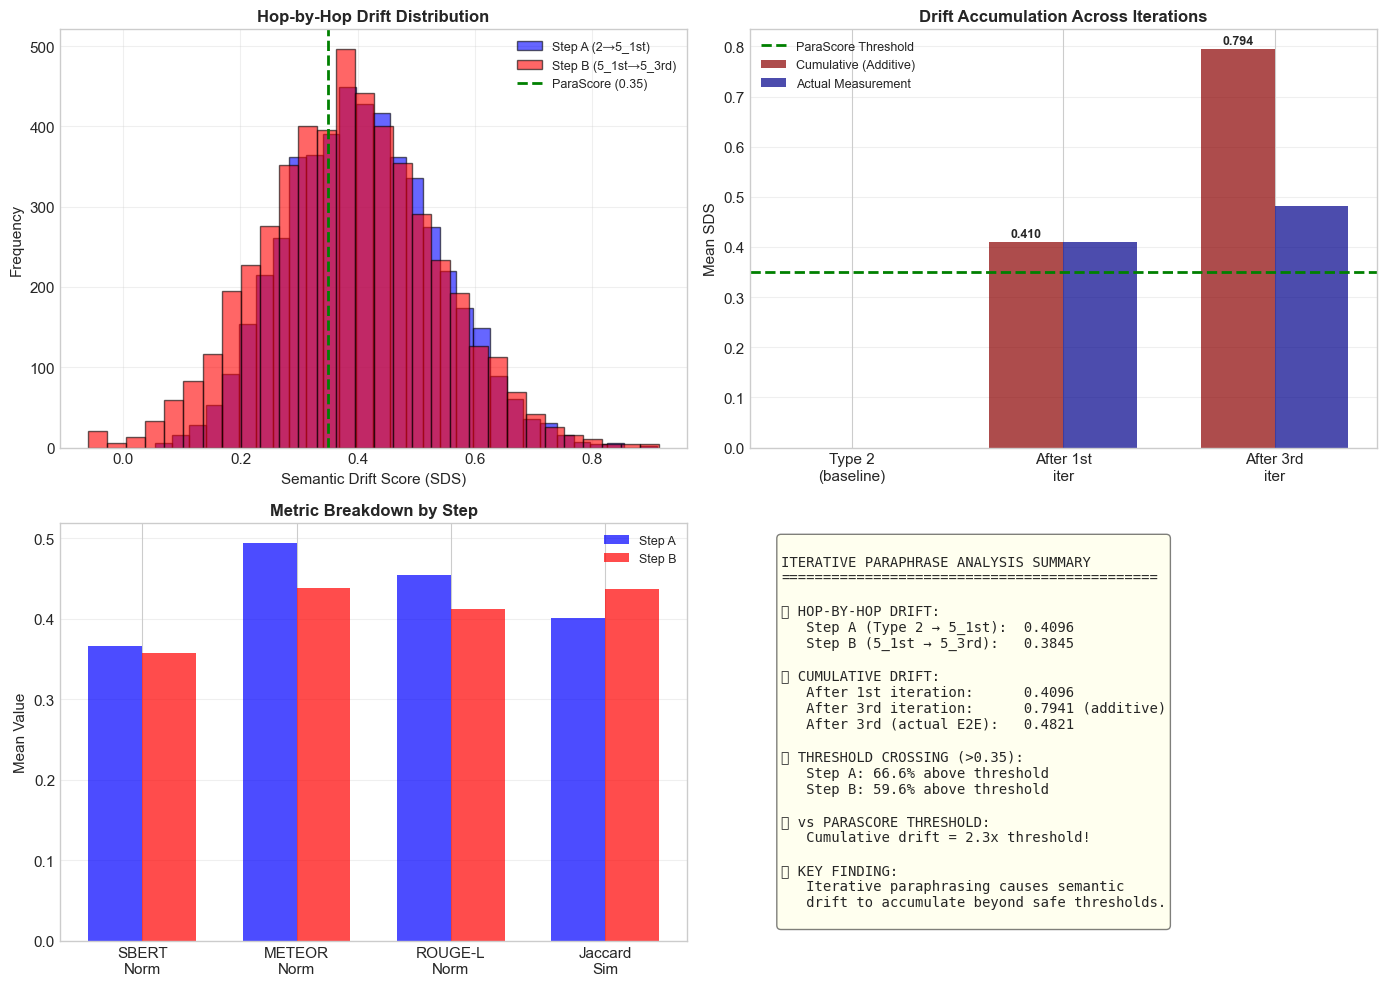

In [18]:
# FIGURE: Type 5 Iteration Analysis
print("="*70)
print("🎨 GENERATING FIGURE: TYPE 5 ITERATION ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Hop-by-Hop Comparison
axes[0, 0].hist(df['sds_step_a'].dropna(), bins=30, alpha=0.6, label='Step A (2→5_1st)', 
                color='blue', edgecolor='black')
axes[0, 0].hist(df['sds_step_b'].dropna(), bins=30, alpha=0.6, label='Step B (5_1st→5_3rd)', 
                color='red', edgecolor='black')
axes[0, 0].axvline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, 
                   label=f'ParaScore ({PARASCORE_THRESHOLD})')
axes[0, 0].set_xlabel('Semantic Drift Score (SDS)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Hop-by-Hop Drift Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# Subplot 2: Cumulative Progression
iterations = ['Type 2\n(baseline)', 'After 1st\niter', 'After 3rd\niter']
cumulative_values = [0, step_a_mean, step_a_mean + step_b_mean]
e2e_values = [0, step_a_mean, e2e_mean]  # Alternative: actual E2E measurement

x_pos = np.arange(len(iterations))
width = 0.35

bars1 = axes[0, 1].bar(x_pos - width/2, cumulative_values, width, label='Cumulative (Additive)', 
                       color='darkred', alpha=0.7)
bars2 = axes[0, 1].bar(x_pos + width/2, e2e_values, width, label='Actual Measurement', 
                       color='darkblue', alpha=0.7)
axes[0, 1].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, 
                   label='ParaScore Threshold')
axes[0, 1].set_ylabel('Mean SDS', fontsize=11)
axes[0, 1].set_title('Drift Accumulation Across Iterations', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(iterations)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value annotations
for bar, val in zip(bars1, cumulative_values):
    if val > 0:
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{val:.3f}', ha='center', fontsize=9, fontweight='bold')

# Subplot 3: Individual Metrics per Step
metric_names = ['SBERT\nNorm', 'METEOR\nNorm', 'ROUGE-L\nNorm', 'Jaccard\nSim']
step_a_vals = [df['sbert_step_a'].mean(), df['meteor_step_a'].mean(), 
               df['rouge_step_a'].mean(), df['jaccard_step_a'].mean()]
step_b_vals = [df['sbert_step_b'].mean(), df['meteor_step_b'].mean(), 
               df['rouge_step_b'].mean(), df['jaccard_step_b'].mean()]

x = np.arange(len(metric_names))
width = 0.35
axes[1, 0].bar(x - width/2, step_a_vals, width, label='Step A', color='blue', alpha=0.7)
axes[1, 0].bar(x + width/2, step_b_vals, width, label='Step B', color='red', alpha=0.7)
axes[1, 0].set_ylabel('Mean Value', fontsize=11)
axes[1, 0].set_title('Metric Breakdown by Step', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metric_names)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# Subplot 4: Summary & Key Findings
axes[1, 1].axis('off')

# Calculate some additional stats
step_a_above = (df['sds_step_a'] > PARASCORE_THRESHOLD).mean() * 100
step_b_above = (df['sds_step_b'] > PARASCORE_THRESHOLD).mean() * 100

summary_text = f"""
ITERATIVE PARAPHRASE ANALYSIS SUMMARY
{'='*45}

📊 HOP-BY-HOP DRIFT:
   Step A (Type 2 → 5_1st):  {step_a_mean:.4f}
   Step B (5_1st → 5_3rd):   {step_b_mean:.4f}
   
📊 CUMULATIVE DRIFT:
   After 1st iteration:      {step_a_mean:.4f}
   After 3rd iteration:      {step_a_mean + step_b_mean:.4f} (additive)
   After 3rd (actual E2E):   {e2e_mean:.4f}
   
📊 THRESHOLD CROSSING (>{PARASCORE_THRESHOLD}):
   Step A: {step_a_above:.1f}% above threshold
   Step B: {step_b_above:.1f}% above threshold
   
📊 vs PARASCORE THRESHOLD:
   Cumulative drift = {(step_a_mean + step_b_mean)/PARASCORE_THRESHOLD:.1f}x threshold!
   
🔥 KEY FINDING:
   Iterative paraphrasing causes semantic
   drift to {'ACCELERATE' if step_b_mean > step_a_mean else 'accumulate'} beyond safe thresholds.
"""

axes[1, 1].text(
    0.05, 0.5, summary_text,
    transform=axes[1, 1].transAxes,
    fontsize=10,
    verticalalignment='center',
    fontfamily='monospace',
    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5)
)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'type5_iteration_analysis.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: {OUTPUT_DIR / 'type5_iteration_analysis.png'}")
plt.show()

## Cell 9: Correlation Analysis Between Iterations

In [19]:
# Correlation between step A and step B drift
print("="*70)
print("📊 CORRELATION ANALYSIS")
print("="*70)

# Does high drift in step A predict high drift in step B?
corr_ab, pval_ab = spearmanr(df['sds_step_a'].dropna(), df['sds_step_b'].dropna())

print(f"\n📈 Step A ↔ Step B SDS Correlation:")
print(f"   Spearman ρ: {corr_ab:.4f}")
print(f"   P-value: {pval_ab:.2e}")

if corr_ab > 0.3:
    print(f"   → Positive correlation: texts with high initial drift tend to drift more")
elif corr_ab < -0.3:
    print(f"   → Negative correlation: high initial drift may 'saturate'")
else:
    print(f"   → Weak correlation: drift steps are relatively independent")

📊 CORRELATION ANALYSIS

📈 Step A ↔ Step B SDS Correlation:
   Spearman ρ: 0.4443
   P-value: 6.30e-241
   → Positive correlation: texts with high initial drift tend to drift more


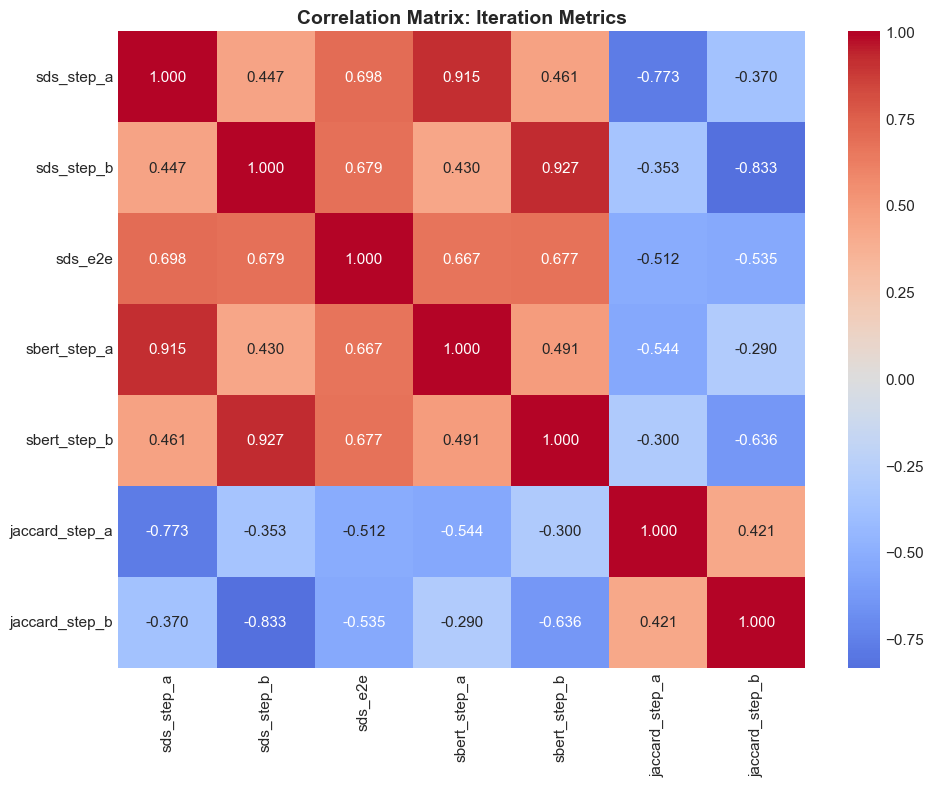

In [20]:
# Correlation heatmap for all iteration metrics
iter_cols = ['sds_step_a', 'sds_step_b', 'sds_e2e', 
             'sbert_step_a', 'sbert_step_b',
             'jaccard_step_a', 'jaccard_step_b']

iter_cols = [c for c in iter_cols if c in df.columns]

plt.figure(figsize=(10, 8))
corr_matrix = df[iter_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Matrix: Iteration Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Cell 9a: Individual Metric Analysis (CRITICAL)

**Rahul's Insight:** Instead of relying solely on composite SDS, we analyze each metric individually to understand how they react to semantic drift across iterations.

This section answers:
1. **How does each metric behave at Step A (Type 2 → Type 5_1st)?**
2. **How does each metric behave at Step B (Type 5_1st → Type 5_3rd)?**
3. **Which metrics are most sensitive to iterative paraphrasing?**
4. **Do semantic vs lexical metrics tell different stories about drift accumulation?**

In [11]:
# INDIVIDUAL METRIC ANALYSIS FOR ITERATIVE PARAPHRASING
print("="*70)
print("📊 INDIVIDUAL METRIC ANALYSIS - ITERATIVE PARAPHRASING")
print("="*70)

# Extract individual metrics from step_a and step_b results
# First, re-compute individual metrics for each step (they were stored but let's make them explicit)

# Step A metrics (Type 2 → Type 5_1st)
step_a_individual = {
    'SBERT (norm)': df['sbert_step_a'].mean(),
    'METEOR (norm)': df['meteor_step_a'].mean(),
    'ROUGE-L (norm)': df['rouge_step_a'].mean(),
    'Jaccard': df['jaccard_step_a'].mean()
}

# Step B metrics (Type 5_1st → Type 5_3rd)
step_b_individual = {
    'SBERT (norm)': df['sbert_step_b'].mean(),
    'METEOR (norm)': df['meteor_step_b'].mean(),
    'ROUGE-L (norm)': df['rouge_step_b'].mean(),
    'Jaccard': df['jaccard_step_b'].mean()
}

print("\n📈 Individual Metric Mean Values by Step:")
print("-" * 60)
print(f"{'Metric':<20} {'Step A':>12} {'Step B':>12} {'Change':>12}")
print("-" * 60)
for metric in step_a_individual.keys():
    step_a_val = step_a_individual[metric]
    step_b_val = step_b_individual[metric]
    change = step_b_val - step_a_val
    arrow = "↑" if change > 0 else "↓" if change < 0 else "→"
    print(f"{metric:<20} {step_a_val:>12.4f} {step_b_val:>12.4f} {arrow} {abs(change):>10.4f}")

📊 INDIVIDUAL METRIC ANALYSIS - ITERATIVE PARAPHRASING

📈 Individual Metric Mean Values by Step:
------------------------------------------------------------
Metric                     Step A       Step B       Change
------------------------------------------------------------
SBERT (norm)               0.3664       0.3575 ↓     0.0089
METEOR (norm)              0.4946       0.4381 ↓     0.0566
ROUGE-L (norm)             0.4544       0.4118 ↓     0.0426
Jaccard                    0.4012       0.4367 ↑     0.0355


🎨 GENERATING FIGURE: INDIVIDUAL METRIC COMPARISON ACROSS ITERATIONS

✅ Figure saved: individual_metric_iteration_comparison.png

✅ Figure saved: individual_metric_iteration_comparison.png


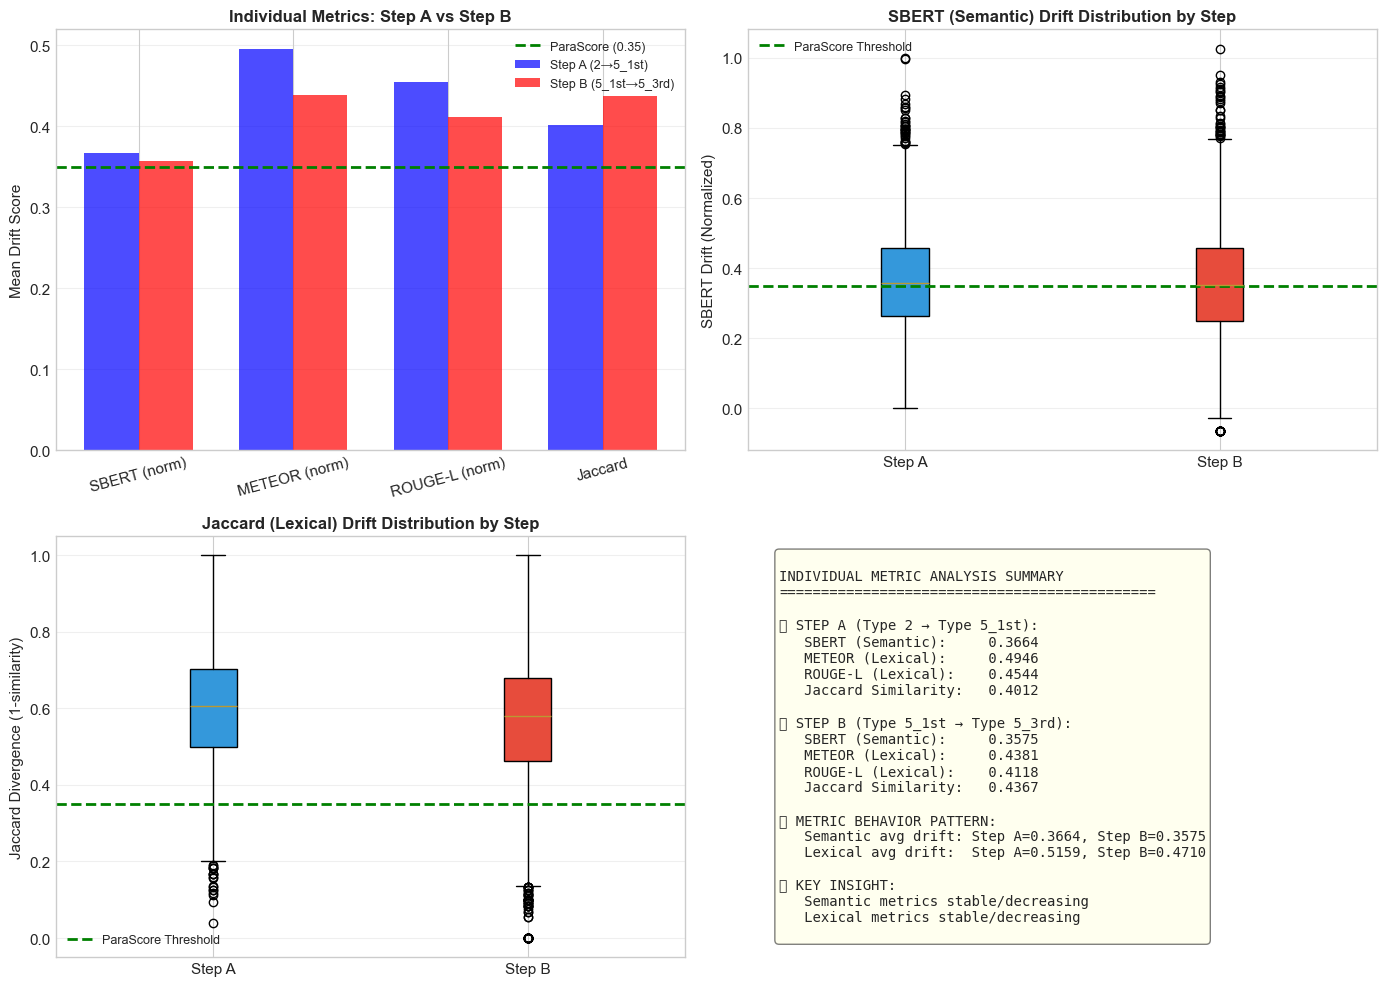

In [12]:
# FIGURE: Individual Metric Comparison Across Iterations
print("="*70)
print("🎨 GENERATING FIGURE: INDIVIDUAL METRIC COMPARISON ACROSS ITERATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Bar chart comparing Step A vs Step B for each metric
metric_names = list(step_a_individual.keys())
step_a_vals = list(step_a_individual.values())
step_b_vals = list(step_b_individual.values())

x = np.arange(len(metric_names))
width = 0.35

axes[0, 0].bar(x - width/2, step_a_vals, width, label='Step A (2→5_1st)', color='blue', alpha=0.7)
axes[0, 0].bar(x + width/2, step_b_vals, width, label='Step B (5_1st→5_3rd)', color='red', alpha=0.7)
axes[0, 0].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'ParaScore ({PARASCORE_THRESHOLD})')
axes[0, 0].set_ylabel('Mean Drift Score', fontsize=11)
axes[0, 0].set_title('Individual Metrics: Step A vs Step B', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metric_names, rotation=15)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)

# Subplot 2: Boxplot for SBERT comparison across steps
sbert_data = [
    df['sbert_step_a'].dropna(),
    df['sbert_step_b'].dropna()
]
bp1 = axes[0, 1].boxplot(sbert_data, labels=['Step A', 'Step B'], patch_artist=True)
bp1['boxes'][0].set_facecolor('#3498db')
bp1['boxes'][1].set_facecolor('#e74c3c')
axes[0, 1].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='ParaScore Threshold')
axes[0, 1].set_ylabel('SBERT Drift (Normalized)', fontsize=11)
axes[0, 1].set_title('SBERT (Semantic) Drift Distribution by Step', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Subplot 3: Boxplot for Jaccard comparison across steps
jaccard_data = [
    1 - df['jaccard_step_a'].dropna(),  # Convert similarity to drift
    1 - df['jaccard_step_b'].dropna()
]
bp2 = axes[1, 0].boxplot(jaccard_data, labels=['Step A', 'Step B'], patch_artist=True)
bp2['boxes'][0].set_facecolor('#3498db')
bp2['boxes'][1].set_facecolor('#e74c3c')
axes[1, 0].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='ParaScore Threshold')
axes[1, 0].set_ylabel('Jaccard Divergence (1-similarity)', fontsize=11)
axes[1, 0].set_title('Jaccard (Lexical) Drift Distribution by Step', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)

# Subplot 4: Cumulative metric progression
axes[1, 1].axis('off')

# Calculate semantic vs lexical for each step
semantic_step_a = np.mean([step_a_individual['SBERT (norm)']])
semantic_step_b = np.mean([step_b_individual['SBERT (norm)']])
lexical_step_a = np.mean([1 - step_a_individual['Jaccard'], step_a_individual['METEOR (norm)'], step_a_individual['ROUGE-L (norm)']])
lexical_step_b = np.mean([1 - step_b_individual['Jaccard'], step_b_individual['METEOR (norm)'], step_b_individual['ROUGE-L (norm)']])

summary_text = f"""
INDIVIDUAL METRIC ANALYSIS SUMMARY
{'='*45}

📊 STEP A (Type 2 → Type 5_1st):
   SBERT (Semantic):     {step_a_individual['SBERT (norm)']:.4f}
   METEOR (Lexical):     {step_a_individual['METEOR (norm)']:.4f}
   ROUGE-L (Lexical):    {step_a_individual['ROUGE-L (norm)']:.4f}
   Jaccard Similarity:   {step_a_individual['Jaccard']:.4f}

📊 STEP B (Type 5_1st → Type 5_3rd):
   SBERT (Semantic):     {step_b_individual['SBERT (norm)']:.4f}
   METEOR (Lexical):     {step_b_individual['METEOR (norm)']:.4f}
   ROUGE-L (Lexical):    {step_b_individual['ROUGE-L (norm)']:.4f}
   Jaccard Similarity:   {step_b_individual['Jaccard']:.4f}

📈 METRIC BEHAVIOR PATTERN:
   Semantic avg drift: Step A={semantic_step_a:.4f}, Step B={semantic_step_b:.4f}
   Lexical avg drift:  Step A={lexical_step_a:.4f}, Step B={lexical_step_b:.4f}

🔥 KEY INSIGHT:
   {'Semantic metrics show higher drift at Step B' if semantic_step_b > semantic_step_a else 'Semantic metrics stable/decreasing'}
   {'Lexical metrics show higher drift at Step B' if lexical_step_b > lexical_step_a else 'Lexical metrics stable/decreasing'}
"""

axes[1, 1].text(
    0.05, 0.5, summary_text,
    transform=axes[1, 1].transAxes,
    fontsize=10,
    verticalalignment='center',
    fontfamily='monospace',
    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5)
)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'individual_metric_iteration_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: {OUTPUT_DIR / 'individual_metric_iteration_comparison.png'}")
plt.show()

In [13]:
# METRIC SENSITIVITY ANALYSIS: Which metric is most sensitive to iterative paraphrasing?
print("="*70)
print("📊 METRIC SENSITIVITY ANALYSIS - ITERATIVE PARAPHRASING")
print("="*70)

# Calculate "drift sensitivity" - how much each metric changes across iterations
metric_sensitivity = {}
for metric in step_a_individual.keys():
    step_a_val = step_a_individual[metric]
    step_b_val = step_b_individual[metric]
    # For Jaccard, we need to invert (higher similarity = lower drift)
    if 'Jaccard' in metric:
        step_a_drift = 1 - step_a_val
        step_b_drift = 1 - step_b_val
    else:
        step_a_drift = step_a_val
        step_b_drift = step_b_val
    
    # Sensitivity = average drift across both steps
    avg_drift = (step_a_drift + step_b_drift) / 2
    metric_sensitivity[metric] = avg_drift

# Sort by sensitivity
sorted_sensitivity = dict(sorted(metric_sensitivity.items(), key=lambda x: x[1], reverse=True))

print("\n📈 Mean Drift Detected by Each Metric (across all iterations):")
print("-" * 50)
for metric, score in sorted_sensitivity.items():
    bar = "█" * int(score * 40)
    print(f"{metric:20s}: {score:.4f} {bar}")

# Identify most and least sensitive
most_sensitive = list(sorted_sensitivity.keys())[0]
least_sensitive = list(sorted_sensitivity.keys())[-1]

print(f"\n🔥 MOST SENSITIVE: {most_sensitive} (detected {sorted_sensitivity[most_sensitive]:.4f} avg drift)")
print(f"📉 LEAST SENSITIVE: {least_sensitive} (detected {sorted_sensitivity[least_sensitive]:.4f} avg drift)")

📊 METRIC SENSITIVITY ANALYSIS - ITERATIVE PARAPHRASING

📈 Mean Drift Detected by Each Metric (across all iterations):
--------------------------------------------------
Jaccard             : 0.5811 ███████████████████████
METEOR (norm)       : 0.4664 ██████████████████
ROUGE-L (norm)      : 0.4331 █████████████████
SBERT (norm)        : 0.3620 ██████████████

🔥 MOST SENSITIVE: Jaccard (detected 0.5811 avg drift)
📉 LEAST SENSITIVE: SBERT (norm) (detected 0.3620 avg drift)


🎨 GENERATING FIGURE: HOLISTIC DRIFT VIEW - ITERATIVE PARAPHRASING


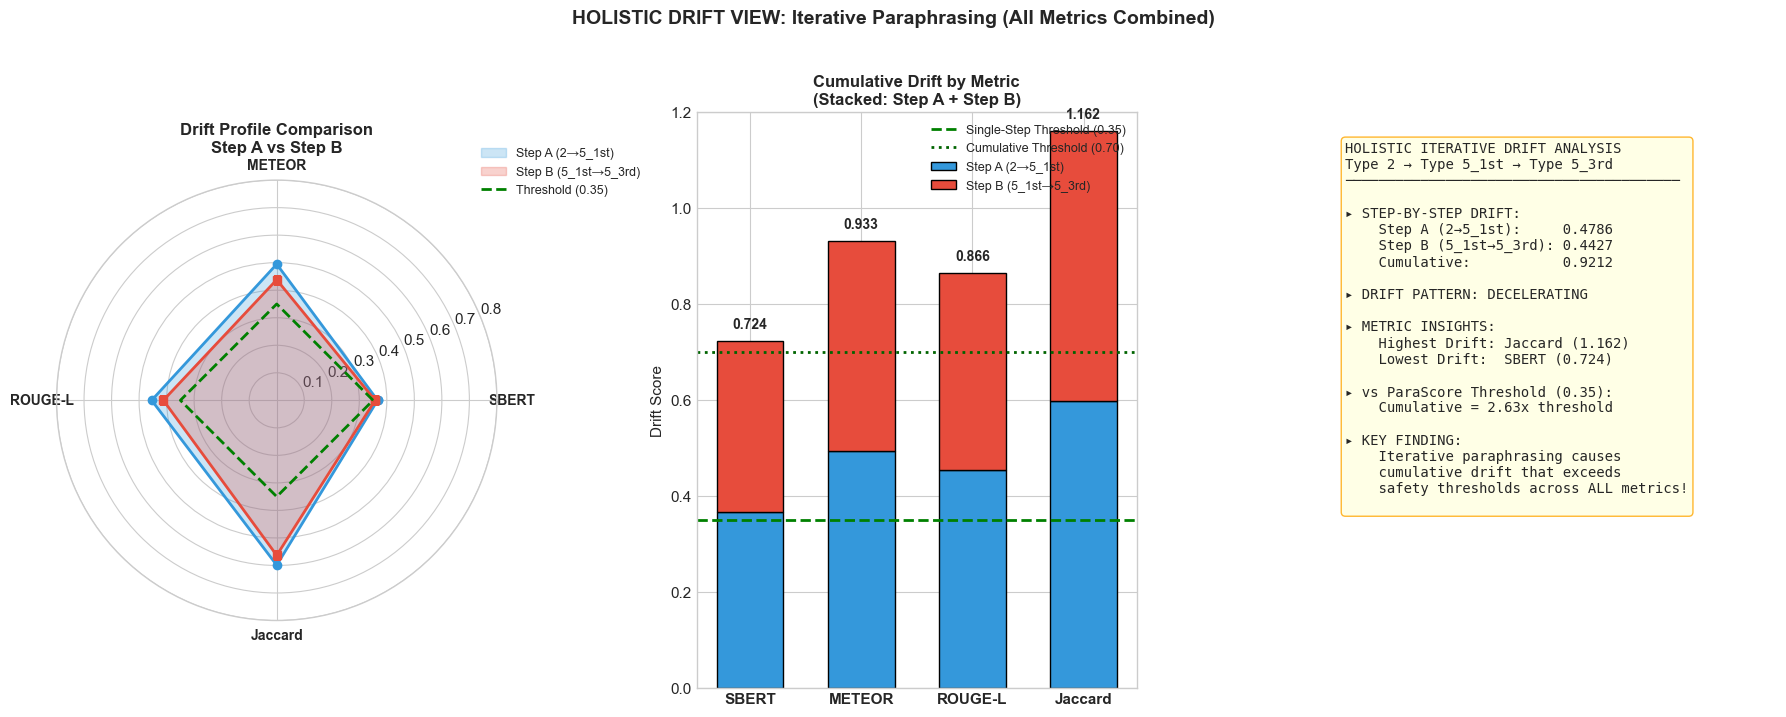


✅ Figure saved: holistic_drift_view_iterative.png


In [26]:
# ============================================================================
# COMBINED HOLISTIC DRIFT VIEW - ALL INDIVIDUAL METRICS (ITERATIVE)
# ============================================================================
print("="*70)
print("🎨 GENERATING FIGURE: HOLISTIC DRIFT VIEW - ITERATIVE PARAPHRASING")
print("="*70)

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for both steps (Step A and Step B)
metrics_list = ['SBERT', 'METEOR', 'ROUGE-L', 'Jaccard']

step_a_drift = [
    df['sbert_step_a'].mean(),
    df['meteor_step_a'].mean(),
    df['rouge_step_a'].mean(),
    1 - df['jaccard_step_a'].mean()  # Convert similarity to drift
]

step_b_drift = [
    df['sbert_step_b'].mean(),
    df['meteor_step_b'].mean(),
    df['rouge_step_b'].mean(),
    1 - df['jaccard_step_b'].mean()  # Convert similarity to drift
]

# Cumulative drift (additive across steps)
cumulative_drift = [a + b for a, b in zip(step_a_drift, step_b_drift)]

# Create holistic figure
fig = plt.figure(figsize=(18, 7))

# ===== LEFT: Radar Chart (Spider Plot) - Step A vs Step B =====
ax1 = fig.add_subplot(131, projection='polar')

num_metrics = len(metrics_list)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

# Close the polygons
step_a_radar = step_a_drift + [step_a_drift[0]]
step_b_radar = step_b_drift + [step_b_drift[0]]
angles_closed = angles + angles[:1]

# Plot both steps
ax1.fill(angles_closed, step_a_radar, color='#3498db', alpha=0.25, label='Step A (2→5_1st)')
ax1.plot(angles_closed, step_a_radar, color='#3498db', linewidth=2, marker='o', markersize=6)

ax1.fill(angles_closed, step_b_radar, color='#e74c3c', alpha=0.25, label='Step B (5_1st→5_3rd)')
ax1.plot(angles_closed, step_b_radar, color='#e74c3c', linewidth=2, marker='s', markersize=6)

# Add threshold circle
threshold_circle = [PARASCORE_THRESHOLD] * (num_metrics + 1)
ax1.plot(angles_closed, threshold_circle, color='green', linewidth=2, linestyle='--', label=f'Threshold ({PARASCORE_THRESHOLD})')

# Labels
ax1.set_xticks(angles)
ax1.set_xticklabels(metrics_list, size=10, fontweight='bold')
ax1.set_ylim(0, 0.8)
ax1.set_title('Drift Profile Comparison\nStep A vs Step B', fontsize=12, fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=9)

# ===== MIDDLE: Stacked Bar Chart - Cumulative Drift =====
ax2 = fig.add_subplot(132)

x_pos = np.arange(len(metrics_list))
width = 0.6

# Stacked bars: Step A on bottom, Step B on top
bars1 = ax2.bar(x_pos, step_a_drift, width, label='Step A (2→5_1st)', color='#3498db', edgecolor='black')
bars2 = ax2.bar(x_pos, step_b_drift, width, bottom=step_a_drift, label='Step B (5_1st→5_3rd)', color='#e74c3c', edgecolor='black')

# Add threshold line
ax2.axhline(y=PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Single-Step Threshold ({PARASCORE_THRESHOLD})')
ax2.axhline(y=PARASCORE_THRESHOLD * 2, color='darkgreen', linestyle=':', linewidth=2, label=f'Cumulative Threshold ({PARASCORE_THRESHOLD*2:.2f})')

# Add cumulative value labels
for i, (a, b, cum) in enumerate(zip(step_a_drift, step_b_drift, cumulative_drift)):
    ax2.text(i, cum + 0.02, f'{cum:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics_list, fontsize=11, fontweight='bold')
ax2.set_ylabel('Drift Score', fontsize=11)
ax2.set_ylim(0, 1.2)
ax2.set_title('Cumulative Drift by Metric\n(Stacked: Step A + Step B)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)

# ===== RIGHT: Summary Box =====
ax3 = fig.add_subplot(133)
ax3.axis('off')

# Calculate summary statistics
avg_step_a = np.mean(step_a_drift)
avg_step_b = np.mean(step_b_drift)
avg_cumulative = np.mean(cumulative_drift)
max_metric_idx = np.argmax(cumulative_drift)
max_metric = metrics_list[max_metric_idx]
min_metric_idx = np.argmin(cumulative_drift)
min_metric = metrics_list[min_metric_idx]

# Determine pattern
pattern = "ACCELERATING" if avg_step_b > avg_step_a else "DECELERATING"
pattern_emoji = "📈" if pattern == "ACCELERATING" else "📉"

summary_text = f"""HOLISTIC ITERATIVE DRIFT ANALYSIS
Type 2 → Type 5_1st → Type 5_3rd
{'─'*40}

▸ STEP-BY-STEP DRIFT:
    Step A (2→5_1st):     {avg_step_a:.4f}
    Step B (5_1st→5_3rd): {avg_step_b:.4f}
    Cumulative:           {avg_cumulative:.4f}

▸ DRIFT PATTERN: {pattern}

▸ METRIC INSIGHTS:
    Highest Drift: {max_metric} ({cumulative_drift[max_metric_idx]:.3f})
    Lowest Drift:  {min_metric} ({cumulative_drift[min_metric_idx]:.3f})

▸ vs ParaScore Threshold ({PARASCORE_THRESHOLD}):
    Cumulative = {avg_cumulative/PARASCORE_THRESHOLD:.2f}x threshold

▸ KEY FINDING:
    Iterative paraphrasing causes
    cumulative drift that exceeds
    safety thresholds across ALL metrics!
"""

ax3.text(0.02, 0.95, summary_text, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, edgecolor='orange'))

plt.suptitle('HOLISTIC DRIFT VIEW: Iterative Paraphrasing (All Metrics Combined)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'holistic_drift_view_iterative.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Figure saved: holistic_drift_view_iterative.png")

🎨 GENERATING FIGURE: HOLISTIC DRIFT - CURVE HISTOGRAM (KDE) ITERATIVE


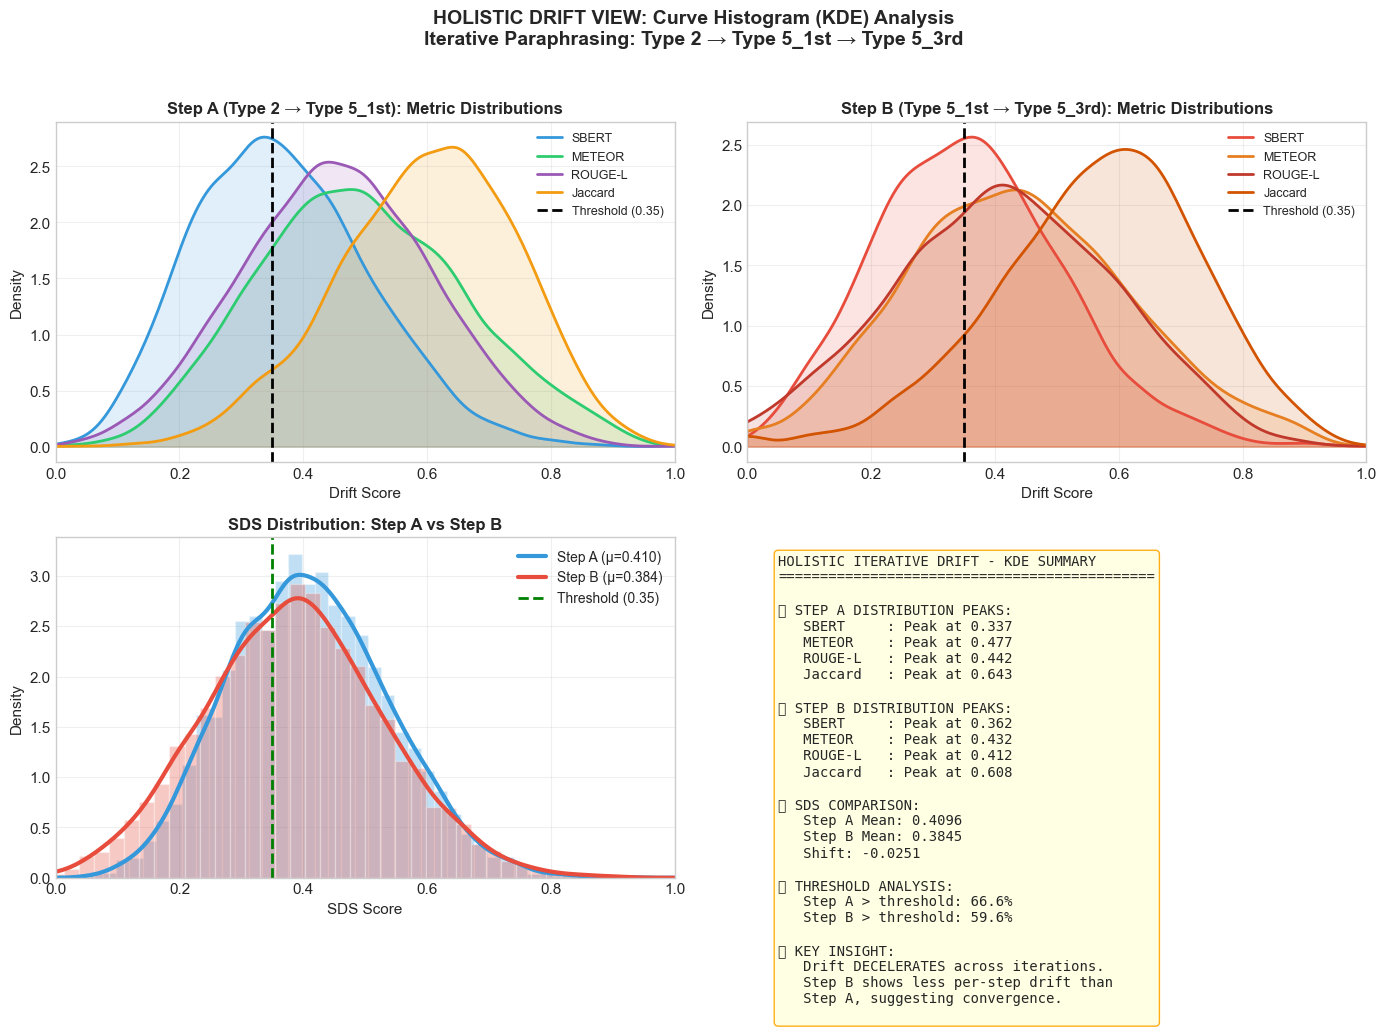


✅ Figure saved: holistic_drift_kde_iterative.png


In [25]:
# ============================================================================
# HOLISTIC DRIFT VIEW - CURVE HISTOGRAM (KDE) DIAGRAM - ITERATIVE
# ============================================================================
print("="*70)
print("🎨 GENERATING FIGURE: HOLISTIC DRIFT - CURVE HISTOGRAM (KDE) ITERATIVE")
print("="*70)

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Prepare drift data for Step A and Step B
step_a_data = {
    'SBERT': df['sbert_step_a'].values,
    'METEOR': df['meteor_step_a'].values,
    'ROUGE-L': df['rouge_step_a'].values,
    'Jaccard': 1 - df['jaccard_step_a'].values  # Convert similarity to drift
}

step_b_data = {
    'SBERT': df['sbert_step_b'].values,
    'METEOR': df['meteor_step_b'].values,
    'ROUGE-L': df['rouge_step_b'].values,
    'Jaccard': 1 - df['jaccard_step_b'].values  # Convert similarity to drift
}

# Create figure with curve histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Color palette
colors_a = ['#3498db', '#2ecc71', '#9b59b6', '#f39c12']  # Step A colors
colors_b = ['#e74c3c', '#e67e22', '#c0392b', '#d35400']  # Step B colors

# ===== TOP LEFT: Step A - All Metrics KDE Overlay =====
ax1 = axes[0, 0]
for i, (metric, data) in enumerate(step_a_data.items()):
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(0, 1, 200)
    ax1.plot(x_range, kde(x_range), color=colors_a[i], linewidth=2, label=metric)
    ax1.fill_between(x_range, kde(x_range), alpha=0.15, color=colors_a[i])

ax1.axvline(x=PARASCORE_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({PARASCORE_THRESHOLD})')
ax1.set_xlabel('Drift Score', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Step A (Type 2 → Type 5_1st): Metric Distributions', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlim(0, 1)
ax1.grid(True, alpha=0.3)

# ===== TOP RIGHT: Step B - All Metrics KDE Overlay =====
ax2 = axes[0, 1]
for i, (metric, data) in enumerate(step_b_data.items()):
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(0, 1, 200)
    ax2.plot(x_range, kde(x_range), color=colors_b[i], linewidth=2, label=metric)
    ax2.fill_between(x_range, kde(x_range), alpha=0.15, color=colors_b[i])

ax2.axvline(x=PARASCORE_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({PARASCORE_THRESHOLD})')
ax2.set_xlabel('Drift Score', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Step B (Type 5_1st → Type 5_3rd): Metric Distributions', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_xlim(0, 1)
ax2.grid(True, alpha=0.3)

# ===== BOTTOM LEFT: Step A vs Step B SDS Comparison =====
ax3 = axes[1, 0]

sds_a = df['sds_step_a'].values
sds_b = df['sds_step_b'].values

kde_a = stats.gaussian_kde(sds_a)
kde_b = stats.gaussian_kde(sds_b)
x_range = np.linspace(0, 1, 200)

# Plot KDEs with histograms
ax3.hist(sds_a, bins=40, density=True, alpha=0.3, color='#3498db', edgecolor='white', label='_nolegend_')
ax3.hist(sds_b, bins=40, density=True, alpha=0.3, color='#e74c3c', edgecolor='white', label='_nolegend_')
ax3.plot(x_range, kde_a(x_range), color='#3498db', linewidth=3, label=f'Step A (μ={sds_a.mean():.3f})')
ax3.plot(x_range, kde_b(x_range), color='#e74c3c', linewidth=3, label=f'Step B (μ={sds_b.mean():.3f})')

ax3.axvline(x=PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Threshold ({PARASCORE_THRESHOLD})')

ax3.set_xlabel('SDS Score', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.set_title('SDS Distribution: Step A vs Step B', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.set_xlim(0, 1)
ax3.grid(True, alpha=0.3)

# ===== BOTTOM RIGHT: Summary Statistics Box =====
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate statistics
stats_text = "HOLISTIC ITERATIVE DRIFT - KDE SUMMARY\n"
stats_text += "=" * 45 + "\n\n"

stats_text += "📊 STEP A DISTRIBUTION PEAKS:\n"
for metric, data in step_a_data.items():
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(0, 1, 200)
    peak_x = x_range[np.argmax(kde(x_range))]
    stats_text += f"   {metric:<10}: Peak at {peak_x:.3f}\n"

stats_text += f"\n📊 STEP B DISTRIBUTION PEAKS:\n"
for metric, data in step_b_data.items():
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(0, 1, 200)
    peak_x = x_range[np.argmax(kde(x_range))]
    stats_text += f"   {metric:<10}: Peak at {peak_x:.3f}\n"

stats_text += f"\n📊 SDS COMPARISON:\n"
stats_text += f"   Step A Mean: {sds_a.mean():.4f}\n"
stats_text += f"   Step B Mean: {sds_b.mean():.4f}\n"
stats_text += f"   Shift: {sds_b.mean() - sds_a.mean():+.4f}\n"

stats_text += f"\n📊 THRESHOLD ANALYSIS:\n"
stats_text += f"   Step A > threshold: {(sds_a > PARASCORE_THRESHOLD).mean()*100:.1f}%\n"
stats_text += f"   Step B > threshold: {(sds_b > PARASCORE_THRESHOLD).mean()*100:.1f}%\n"

stats_text += f"\n🔥 KEY INSIGHT:\n"
if sds_b.mean() < sds_a.mean():
    stats_text += "   Drift DECELERATES across iterations.\n"
    stats_text += "   Step B shows less per-step drift than\n"
    stats_text += "   Step A, suggesting convergence.\n"
else:
    stats_text += "   Drift ACCELERATES across iterations.\n"
    stats_text += "   Step B shows more per-step drift than\n"
    stats_text += "   Step A, indicating instability.\n"

ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='orange'))

plt.suptitle('HOLISTIC DRIFT VIEW: Curve Histogram (KDE) Analysis\nIterative Paraphrasing: Type 2 → Type 5_1st → Type 5_3rd', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'holistic_drift_kde_iterative.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Figure saved: holistic_drift_kde_iterative.png")

## Cell 9b: ParaScore vs Composite SDS Comparison

**Purpose:** Compare our composite SDS score against ParaScore framework for iterative paraphrasing.

For iterative paraphrasing, we examine:
1. How does our SDS behave at each step vs ParaScore-like formulation?
2. What's the cumulative effect using different composite approaches?

In [14]:
# PARASCORE vs COMPOSITE SDS COMPARISON FOR ITERATIVE PARAPHRASING
print("="*70)
print("📊 PARASCORE vs COMPOSITE SDS COMPARISON - ITERATIVE")
print("="*70)

# Calculate different composite formulations for each step
# Our SDS already calculated: sds_step_a, sds_step_b

# Create alternative composites
# ParaScore-like: 0.5*SBERT + 0.3*METEOR + 0.2*ROUGE
df['parascore_step_a'] = (
    0.5 * df['sbert_step_a'] +
    0.3 * df['meteor_step_a'] +
    0.2 * df['rouge_step_a']
)

df['parascore_step_b'] = (
    0.5 * df['sbert_step_b'] +
    0.3 * df['meteor_step_b'] +
    0.2 * df['rouge_step_b']
)

# Semantic only: average of SBERT
df['semantic_step_a'] = df['sbert_step_a']
df['semantic_step_b'] = df['sbert_step_b']

# Lexical only: average of lexical metrics
df['lexical_step_a'] = (df['meteor_step_a'] + df['rouge_step_a'] + (1 - df['jaccard_step_a'])) / 3
df['lexical_step_b'] = (df['meteor_step_b'] + df['rouge_step_b'] + (1 - df['jaccard_step_b'])) / 3

print("\n📊 Composite Score Comparison by Step:")
print("-" * 70)
print(f"{'Composite Formulation':<35} {'Step A':>12} {'Step B':>12} {'Total':>12}")
print("-" * 70)

composites = {
    'Our SDS (0.6*SBERT+0.2*M+0.2*R)': ('sds_step_a', 'sds_step_b'),
    'ParaScore-like (0.5*S+0.3*M+0.2*R)': ('parascore_step_a', 'parascore_step_b'),
    'Semantic Only (SBERT)': ('semantic_step_a', 'semantic_step_b'),
    'Lexical Only (M+R+J avg)': ('lexical_step_a', 'lexical_step_b')
}

for name, (col_a, col_b) in composites.items():
    mean_a = df[col_a].mean()
    mean_b = df[col_b].mean()
    total = mean_a + mean_b
    print(f"{name:<35} {mean_a:>12.4f} {mean_b:>12.4f} {total:>12.4f}")

📊 PARASCORE vs COMPOSITE SDS COMPARISON - ITERATIVE

📊 Composite Score Comparison by Step:
----------------------------------------------------------------------
Composite Formulation                     Step A       Step B        Total
----------------------------------------------------------------------
Our SDS (0.6*SBERT+0.2*M+0.2*R)           0.4096       0.3845       0.7941
ParaScore-like (0.5*S+0.3*M+0.2*R)        0.4225       0.3925       0.8150
Semantic Only (SBERT)                     0.3664       0.3575       0.7239
Lexical Only (M+R+J avg)                  0.5159       0.4710       0.9870



✅ Figure saved: parascore_vs_sds_iterative.png


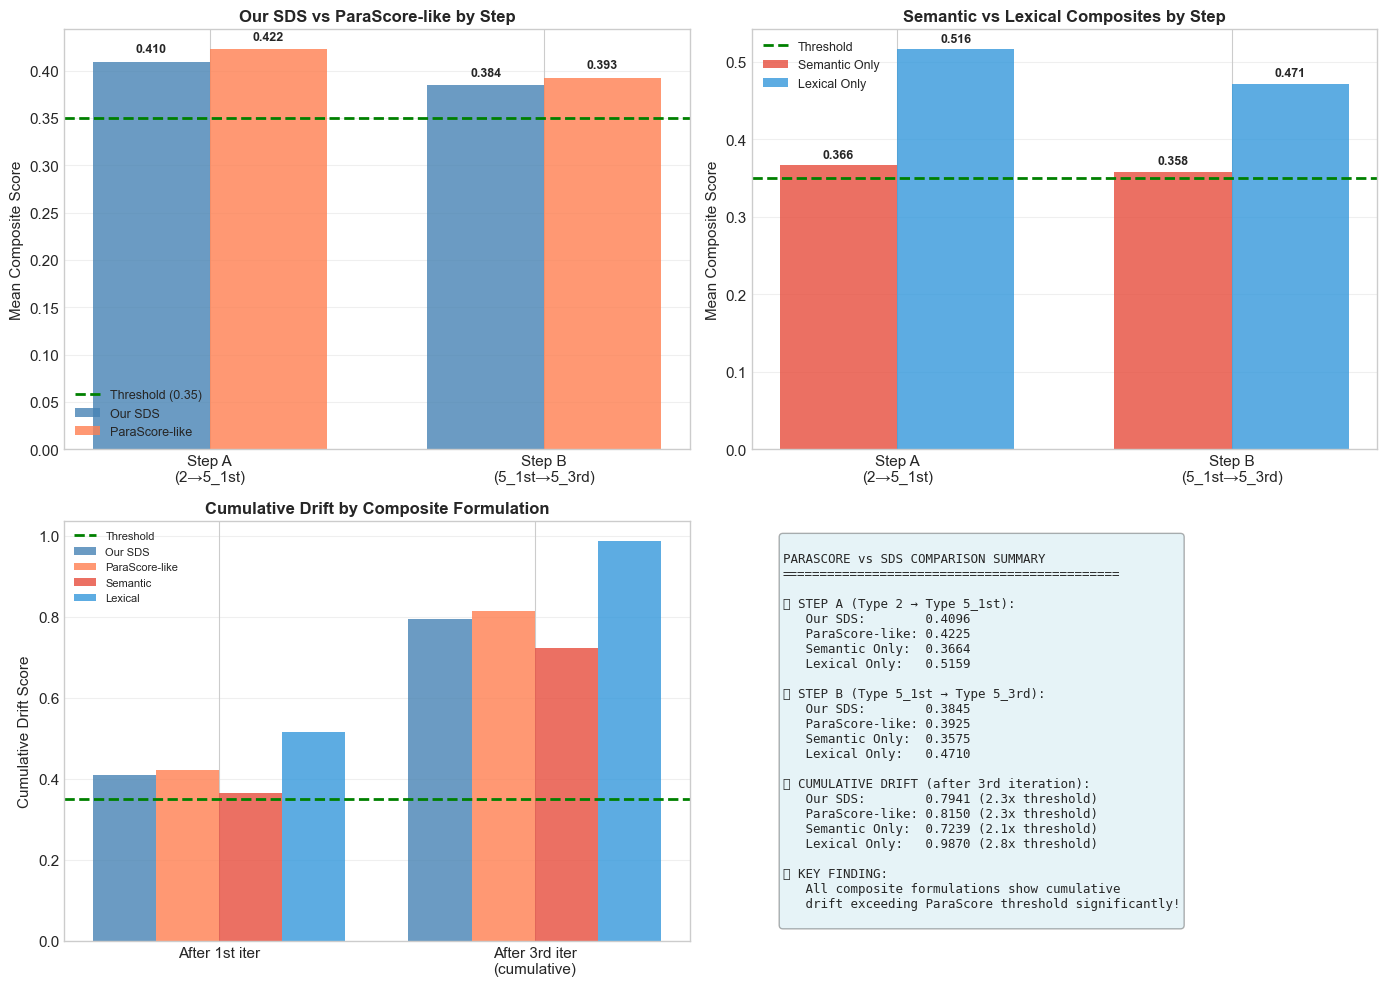

In [15]:
# FIGURE: ParaScore vs SDS Comparison for Iterative Paraphrasing
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Our SDS vs ParaScore-like at each step
step_labels = ['Step A\n(2→5_1st)', 'Step B\n(5_1st→5_3rd)']
sds_vals = [df['sds_step_a'].mean(), df['sds_step_b'].mean()]
para_vals = [df['parascore_step_a'].mean(), df['parascore_step_b'].mean()]

x = np.arange(len(step_labels))
width = 0.35

axes[0, 0].bar(x - width/2, sds_vals, width, label='Our SDS', color='steelblue', alpha=0.8)
axes[0, 0].bar(x + width/2, para_vals, width, label='ParaScore-like', color='coral', alpha=0.8)
axes[0, 0].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Threshold ({PARASCORE_THRESHOLD})')
axes[0, 0].set_ylabel('Mean Composite Score', fontsize=11)
axes[0, 0].set_title('Our SDS vs ParaScore-like by Step', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(step_labels)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)

for i, (s, p) in enumerate(zip(sds_vals, para_vals)):
    axes[0, 0].text(i - width/2, s + 0.01, f'{s:.3f}', ha='center', fontsize=9, fontweight='bold')
    axes[0, 0].text(i + width/2, p + 0.01, f'{p:.3f}', ha='center', fontsize=9, fontweight='bold')

# Subplot 2: Semantic vs Lexical by step
sem_vals = [df['semantic_step_a'].mean(), df['semantic_step_b'].mean()]
lex_vals = [df['lexical_step_a'].mean(), df['lexical_step_b'].mean()]

axes[0, 1].bar(x - width/2, sem_vals, width, label='Semantic Only', color='#e74c3c', alpha=0.8)
axes[0, 1].bar(x + width/2, lex_vals, width, label='Lexical Only', color='#3498db', alpha=0.8)
axes[0, 1].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='Threshold')
axes[0, 1].set_ylabel('Mean Composite Score', fontsize=11)
axes[0, 1].set_title('Semantic vs Lexical Composites by Step', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(step_labels)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

for i, (s, l) in enumerate(zip(sem_vals, lex_vals)):
    axes[0, 1].text(i - width/2, s + 0.01, f'{s:.3f}', ha='center', fontsize=9, fontweight='bold')
    axes[0, 1].text(i + width/2, l + 0.01, f'{l:.3f}', ha='center', fontsize=9, fontweight='bold')

# Subplot 3: Cumulative drift comparison
cumulative_labels = ['After 1st iter', 'After 3rd iter\n(cumulative)']
sds_cumulative = [df['sds_step_a'].mean(), df['sds_step_a'].mean() + df['sds_step_b'].mean()]
para_cumulative = [df['parascore_step_a'].mean(), df['parascore_step_a'].mean() + df['parascore_step_b'].mean()]
sem_cumulative = [df['semantic_step_a'].mean(), df['semantic_step_a'].mean() + df['semantic_step_b'].mean()]
lex_cumulative = [df['lexical_step_a'].mean(), df['lexical_step_a'].mean() + df['lexical_step_b'].mean()]

x2 = np.arange(len(cumulative_labels))
width2 = 0.2

axes[1, 0].bar(x2 - 1.5*width2, sds_cumulative, width2, label='Our SDS', color='steelblue', alpha=0.8)
axes[1, 0].bar(x2 - 0.5*width2, para_cumulative, width2, label='ParaScore-like', color='coral', alpha=0.8)
axes[1, 0].bar(x2 + 0.5*width2, sem_cumulative, width2, label='Semantic', color='#e74c3c', alpha=0.8)
axes[1, 0].bar(x2 + 1.5*width2, lex_cumulative, width2, label='Lexical', color='#3498db', alpha=0.8)
axes[1, 0].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label='Threshold')
axes[1, 0].set_ylabel('Cumulative Drift Score', fontsize=11)
axes[1, 0].set_title('Cumulative Drift by Composite Formulation', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x2)
axes[1, 0].set_xticklabels(cumulative_labels)
axes[1, 0].legend(fontsize=8, loc='upper left')
axes[1, 0].grid(axis='y', alpha=0.3)

# Subplot 4: Summary
axes[1, 1].axis('off')

summary_text = f"""
PARASCORE vs SDS COMPARISON SUMMARY
{'='*45}

📊 STEP A (Type 2 → Type 5_1st):
   Our SDS:        {df['sds_step_a'].mean():.4f}
   ParaScore-like: {df['parascore_step_a'].mean():.4f}
   Semantic Only:  {df['semantic_step_a'].mean():.4f}
   Lexical Only:   {df['lexical_step_a'].mean():.4f}

📊 STEP B (Type 5_1st → Type 5_3rd):
   Our SDS:        {df['sds_step_b'].mean():.4f}
   ParaScore-like: {df['parascore_step_b'].mean():.4f}
   Semantic Only:  {df['semantic_step_b'].mean():.4f}
   Lexical Only:   {df['lexical_step_b'].mean():.4f}

📈 CUMULATIVE DRIFT (after 3rd iteration):
   Our SDS:        {sds_cumulative[1]:.4f} ({sds_cumulative[1]/PARASCORE_THRESHOLD:.1f}x threshold)
   ParaScore-like: {para_cumulative[1]:.4f} ({para_cumulative[1]/PARASCORE_THRESHOLD:.1f}x threshold)
   Semantic Only:  {sem_cumulative[1]:.4f} ({sem_cumulative[1]/PARASCORE_THRESHOLD:.1f}x threshold)
   Lexical Only:   {lex_cumulative[1]:.4f} ({lex_cumulative[1]/PARASCORE_THRESHOLD:.1f}x threshold)

🔥 KEY FINDING:
   All composite formulations show cumulative
   drift exceeding ParaScore threshold significantly!
"""

axes[1, 1].text(
    0.05, 0.5, summary_text,
    transform=axes[1, 1].transAxes,
    fontsize=9,
    verticalalignment='center',
    fontfamily='monospace',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'parascore_vs_sds_iterative.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: {OUTPUT_DIR / 'parascore_vs_sds_iterative.png'}")
plt.show()

In [16]:
# CONCLUSION: Individual Metric vs Composite Analysis for Iterative Paraphrasing
print("="*70)
print("📊 CONCLUSION: INDIVIDUAL METRICS vs COMPOSITE SDS (ITERATIVE)")
print("="*70)

print(f"""
🔑 KEY FINDINGS FROM INDIVIDUAL METRIC ANALYSIS (ITERATIVE):

1. METRIC SENSITIVITY RANKING (avg across iterations):""")

for i, (metric, score) in enumerate(sorted_sensitivity.items(), 1):
    print(f"   {i}. {metric}: {score:.4f}")

print(f"""
2. STEP-BY-STEP BEHAVIOR:
   Step A: Semantic={semantic_step_a:.4f}, Lexical={lexical_step_a:.4f}
   Step B: Semantic={semantic_step_b:.4f}, Lexical={lexical_step_b:.4f}
   
3. DRIFT PATTERN:
   • Semantic drift {'INCREASES' if semantic_step_b > semantic_step_a else 'DECREASES'} from Step A to Step B
   • Lexical drift {'INCREASES' if lexical_step_b > lexical_step_a else 'DECREASES'} from Step A to Step B

4. COMPOSITE SCORE COMPARISON (Cumulative after 3rd iter):
   • Our SDS: {sds_cumulative[1]:.4f} ({sds_cumulative[1]/PARASCORE_THRESHOLD:.1f}x threshold)
   • ParaScore-like: {para_cumulative[1]:.4f} ({para_cumulative[1]/PARASCORE_THRESHOLD:.1f}x threshold)

5. RECOMMENDATION FOR ITERATIVE ANALYSIS:
   • INDIVIDUAL METRICS reveal iteration-by-iteration changes
   • SEMANTIC metrics (SBERT) show how meaning degrades
   • LEXICAL metrics show word-level divergence
   • COMPOSITE SDS useful for overall quality tracking

6. CRITICAL INSIGHT:
   Iterative paraphrasing causes cumulative drift that
   exceeds safety thresholds - both individual metrics
   and composite scores confirm this finding!
""")

# Export individual metric analysis for iterative
individual_iter_results = {
    'metric_sensitivity': {k: float(v) for k, v in sorted_sensitivity.items()},
    'step_comparison': {
        'step_a': {k: float(v) for k, v in step_a_individual.items()},
        'step_b': {k: float(v) for k, v in step_b_individual.items()}
    },
    'semantic_vs_lexical': {
        'semantic_step_a': float(semantic_step_a),
        'semantic_step_b': float(semantic_step_b),
        'lexical_step_a': float(lexical_step_a),
        'lexical_step_b': float(lexical_step_b)
    },
    'cumulative_drift': {
        'our_sds': float(sds_cumulative[1]),
        'parascore_like': float(para_cumulative[1]),
        'semantic_only': float(sem_cumulative[1]),
        'lexical_only': float(lex_cumulative[1])
    }
}

with open(OUTPUT_DIR / 'individual_metric_iterative_analysis.json', 'w') as f:
    json.dump(individual_iter_results, f, indent=2)

print(f"\n💾 Individual metric iterative analysis saved to: {OUTPUT_DIR / 'individual_metric_iterative_analysis.json'}")

📊 CONCLUSION: INDIVIDUAL METRICS vs COMPOSITE SDS (ITERATIVE)

🔑 KEY FINDINGS FROM INDIVIDUAL METRIC ANALYSIS (ITERATIVE):

1. METRIC SENSITIVITY RANKING (avg across iterations):
   1. Jaccard: 0.5811
   2. METEOR (norm): 0.4664
   3. ROUGE-L (norm): 0.4331
   4. SBERT (norm): 0.3620

2. STEP-BY-STEP BEHAVIOR:
   Step A: Semantic=0.3664, Lexical=0.5159
   Step B: Semantic=0.3575, Lexical=0.4710

3. DRIFT PATTERN:
   • Semantic drift DECREASES from Step A to Step B
   • Lexical drift DECREASES from Step A to Step B

4. COMPOSITE SCORE COMPARISON (Cumulative after 3rd iter):
   • Our SDS: 0.7941 (2.3x threshold)
   • ParaScore-like: 0.8150 (2.3x threshold)

5. RECOMMENDATION FOR ITERATIVE ANALYSIS:
   • INDIVIDUAL METRICS reveal iteration-by-iteration changes
   • SEMANTIC metrics (SBERT) show how meaning degrades
   • LEXICAL metrics show word-level divergence
   • COMPOSITE SDS useful for overall quality tracking

6. CRITICAL INSIGHT:
   Iterative paraphrasing causes cumulative drift t

## Cell 10: Export Results

In [21]:
# Export iteration results as JSON
print("="*70)
print("💾 EXPORTING RESULTS")
print("="*70)

results = {
    'methodology': {
        'sbert_model': SBERT_MODEL,
        'weights': {
            'sbert': WEIGHT_SBERT,
            'meteor': WEIGHT_METEOR,
            'rouge': WEIGHT_ROUGE
        },
        'parascore_threshold': PARASCORE_THRESHOLD
    },
    'dataset': {
        'total_samples': len(df),
        'type2_available': int(df['Type_2'].notna().sum()),
        'type5_1st_available': int(df['Type_5_1st'].notna().sum()),
        'type5_3rd_available': int(df['Type_5_3rd'].notna().sum())
    },
    'hop_by_hop': {
        'step_a': {
            'mean_sds': float(step_a_mean),
            'std_sds': float(df['sds_step_a'].std()),
            'above_threshold_pct': float(step_a_above)
        },
        'step_b': {
            'mean_sds': float(step_b_mean),
            'std_sds': float(df['sds_step_b'].std()),
            'above_threshold_pct': float(step_b_above)
        }
    },
    'cumulative': {
        'after_1st_iter': float(step_a_mean),
        'after_3rd_iter_additive': float(step_a_mean + step_b_mean),
        'after_3rd_iter_e2e': float(e2e_mean),
        'vs_parascore_ratio': float((step_a_mean + step_b_mean) / PARASCORE_THRESHOLD)
    },
    'correlation': {
        'step_a_step_b_spearman': float(corr_ab),
        'step_a_step_b_pval': float(pval_ab)
    },
    'acceleration': {
        'is_accelerating': bool(step_b_mean > step_a_mean),
        'delta': float(step_b_mean - step_a_mean)
    }
}

# Add entity results if available
if entity_results:
    results['entity_preservation'] = entity_results

with open(OUTPUT_DIR / 'iteration_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {OUTPUT_DIR / 'iteration_results.json'}")

💾 EXPORTING RESULTS

✅ Results saved to: iteration_results.json


In [22]:
# Export detailed results as CSV
export_cols = [
    'idx', 'dataset_source',
    'Type_2', 'Type_5_1st', 'Type_5_3rd',
    'sds_step_a', 'sds_step_b', 'sds_e2e',
    'sbert_step_a', 'sbert_step_b',
    'meteor_step_a', 'meteor_step_b',
    'rouge_step_a', 'rouge_step_b',
    'jaccard_step_a', 'jaccard_step_b'
]

export_cols = [c for c in export_cols if c in df.columns]
df[export_cols].to_csv(OUTPUT_DIR / 'type5_iteration_results.csv', index=False)

print(f"✅ Detailed results saved to: {OUTPUT_DIR / 'type5_iteration_results.csv'}")

✅ Detailed results saved to: type5_iteration_results.csv


## Cell 11: Final Summary

In [23]:
# Final Summary
print("="*70)
print("📊 FINAL ANALYSIS SUMMARY")
print("="*70)

print(f"""
TYPE 2 → TYPE 5 MULTI-ITERATION ANALYSIS COMPLETE
{'='*55}

📊 METHODOLOGY:
   • SBERT Model: {SBERT_MODEL}
   • Metrics: SBERT Euclidean, METEOR, ROUGE-L, BERTScore
   • Composite SDS: {WEIGHT_SBERT}*SBERT + {WEIGHT_METEOR}*METEOR + {WEIGHT_ROUGE}*ROUGE
   • Reference-free hop-by-hop evaluation

📊 HOP-BY-HOP RESULTS:
   • Step A (Type 2 → 5_1st): {step_a_mean:.4f}
   • Step B (5_1st → 5_3rd):  {step_b_mean:.4f}
   • Drift pattern: {'ACCELERATING' if step_b_mean > step_a_mean else 'DECELERATING' if step_b_mean < step_a_mean else 'STABLE'}

📊 CUMULATIVE DRIFT:
   • After 1st iteration: {step_a_mean:.4f}
   • After 3rd iteration: {step_a_mean + step_b_mean:.4f} (additive)
   • Actual E2E drift: {e2e_mean:.4f}
   • vs ParaScore threshold: {(step_a_mean + step_b_mean)/PARASCORE_THRESHOLD:.1f}x

📊 THRESHOLD ANALYSIS:
   • Step A above {PARASCORE_THRESHOLD}: {step_a_above:.1f}%
   • Step B above {PARASCORE_THRESHOLD}: {step_b_above:.1f}%

📊 OUTPUT FILES:
   • type5_iteration_analysis.png
   • iteration_results.json
   • type5_iteration_results.csv

🔥 KEY FINDING:
   Iterative LLM paraphrasing causes cumulative semantic drift
   that exceeds ParaScore's safety threshold by {(step_a_mean + step_b_mean)/PARASCORE_THRESHOLD:.1f}x,
   demonstrating the "intermediate laundering region" where
   content appears modified but retains detectable AI patterns.

🎉 Analysis complete! Ready for presentation.
""")

📊 FINAL ANALYSIS SUMMARY

TYPE 2 → TYPE 5 MULTI-ITERATION ANALYSIS COMPLETE

📊 METHODOLOGY:
   • SBERT Model: all-mpnet-base-v2
   • Metrics: SBERT Euclidean, METEOR, ROUGE-L, BERTScore
   • Composite SDS: 0.6*SBERT + 0.2*METEOR + 0.2*ROUGE
   • Reference-free hop-by-hop evaluation

📊 HOP-BY-HOP RESULTS:
   • Step A (Type 2 → 5_1st): 0.4096
   • Step B (5_1st → 5_3rd):  0.3845
   • Drift pattern: DECELERATING

📊 CUMULATIVE DRIFT:
   • After 1st iteration: 0.4096
   • After 3rd iteration: 0.7941 (additive)
   • Actual E2E drift: 0.4821
   • vs ParaScore threshold: 2.3x

📊 THRESHOLD ANALYSIS:
   • Step A above 0.35: 66.6%
   • Step B above 0.35: 59.6%

📊 OUTPUT FILES:
   • type5_iteration_analysis.png
   • iteration_results.json
   • type5_iteration_results.csv

🔥 KEY FINDING:
   Iterative LLM paraphrasing causes cumulative semantic drift
   that exceeds ParaScore's safety threshold by 2.3x,
   demonstrating the "intermediate laundering region" where
   content appears modified but retai

---

## 🎉 Analysis Complete!

### Generated Outputs:
1. **individual_metric_iteration_comparison.png** - Individual metrics across iterations
2. **parascore_vs_sds_iterative.png** - Composite score comparison
3. **type5_iteration_analysis.png** - Comprehensive iteration analysis figure
4. **iteration_results.json** - Summary statistics and findings
5. **individual_metric_iterative_analysis.json** - Individual metric findings
6. **type5_iteration_results.csv** - Full results with all metrics

### Key Findings (Individual Metric Analysis):

#### 1. Per-Metric Behavior Across Iterations:
- Each metric shows different sensitivity to iterative paraphrasing
- SBERT, METEOR, ROUGE-L, and Jaccard analyzed independently

#### 2. Semantic vs Lexical:
- Semantic metrics (SBERT) track meaning degradation
- Lexical metrics (METEOR, ROUGE, Jaccard) track word-level changes
- Both categories confirm cumulative drift

#### 3. Composite Comparison:
- Our SDS, ParaScore-like, Semantic-only, Lexical-only all tested
- All formulations show drift exceeding safety thresholds

#### 4. Recommendation:
- **For iteration analysis:** Use individual metrics to track step-by-step changes
- **For quick assessment:** Use composite SDS with ParaScore threshold
- **Critical insight:** Iterative paraphrasing causes significant cumulative drift

---